In [1]:
%matplotlib inline 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Import data & clean

In [3]:
df = pd.read_excel('Quranic Pronouns.xlsx')

In [4]:
df = df.replace('?', np.NaN).iloc[:, 1:16]

In [5]:
columns = {
    'Shelfmark': 'shelfmark', 
    'Ṣilat hāʿ (primary color)' : 'singular', 
    'biHU (primary color)' : 'bihu', 
    'Ṣilat mīm (primary color)' : 'plural', 
    '-ayhum (primary color)' : 'ayhum',
    '-īhim (primary color)' : 'ihim',
    '-ayhum +wasl (primary color)' : 'ayhum_wasl',
    'Style' : 'style'
}

main_cols = ['shelfmark', 'singular', 'bihu', 'plural', 'ayhum', 'ihim', 'ayhum_wasl', 'style']

In [6]:
df = df.rename(columns=columns)

In [7]:
df_main = df.loc[:, main_cols].copy()
df_main.loc[:, main_cols[1:-1]] = df_main[main_cols[1:-1]].apply(lambda x: x.str.lower().str.strip(), axis=1)

## Cross tabulations/correlations on primary color

Drop all ambiguous cases for this initial table since we are concerned with unambiguous systems

In [8]:
df_clear = df_main[
    (df_main.plural != 'short/warsh') & 
    ~df_main.singular.str.contains('[(/]').astype(bool)
]

In [9]:
df_systems = df_clear.groupby(['singular', 'bihu', 'plural']).size().reset_index(name='count')

In [10]:
df_systems['percent'] = df_systems['count']/df_systems['count'].sum()*100

In [11]:
df_systems

,singular,bihu,plural,count,percent
0,harmonized,bihi,long,24,8.333333
1,harmonized,bihi,short,149,51.736111
2,harmonized,bihi,warsh,63,21.875000
3,unharmonized,bihi,long,46,15.972222
4,unharmonized,bihi,short,1,0.347222
5,unharmonized,bihu,long,5,1.736111


### Look at classical system in more detail

In [12]:
df_classical = df_clear[
    (df_clear.singular == 'harmonized') & 
    (df_clear.bihu == 'bihi') & 
    (df_clear.plural == 'short') & 
    df_clear.ayhum_wasl.isin(['himi', 'himu', 'humu'])
]

In [13]:
df_classical.ayhum_wasl.value_counts(normalize=True), df_classical.ayhum_wasl.value_counts(normalize=False)

(himi    0.500000
 himu    0.326087
 humu    0.173913
 Name: ayhum_wasl, dtype: float64, himi    23
 himu    15
 humu     8
 Name: ayhum_wasl, dtype: int64)

## Script style cross tab

In [15]:
df_clear[df_clear['style'].fillna('').str.contains('B.I[ab]')]

,shelfmark,singular,bihu,plural,ayhum,ihim,ayhum_wasl,style
3,Arabe 6087=Wetzstein II 1913,unharmonized,bihu,long,NaN,NaN,NaN,B.Ia
4,Arabe 6140b/CUL Add. 1146,harmonized,bihi,short,NaN,NaN,himu,B.Ib
5,Arabe 325a,harmonized,bihi,warsh,him,NaN,himu,B.Ib
7,Arabe 330b,harmonized,bihi,short,hum,NaN,NaN,B.Ib
8,Arabe 333b,harmonized,bihi,short,NaN,NaN,NaN,B.Ib
9,Arabe 335,unharmonized,bihi,long,him,hum,NaN,B.Ib
10,Arabe 6140g,harmonized,bihi,long,NaN,NaN,NaN,B.Ib
255,Tubingen,harmonized,bihi,long,NaN,NaN,hvmu,B.Ia
392,NM. C.7th CE/56.62/4,unharmonized,NaN,long,NaN,NaN,NaN,B.Ib


In [16]:
df_clear_ss = df_clear#[~df_clear.ayhum_wasl.str.contains('[(/?]').astype(bool)]

In [17]:
df_script = pd.crosstab(df_clear_ss['style'], [
    df_clear_ss.singular, 
    df_clear_ss.bihu, 
    df_clear_ss.plural], 
    margins=True, dropna=True)

In [18]:
df_script_ss = df_script[df_script['All'] > 4]

In [19]:
df_script_ss

singular     harmonized             unharmonized             All
bihu               bihi                     bihi       bihu     
plural             long short warsh         long short long     
style                                                           
B.II                  2     5     2           20     1    0   30
B.Ib                  1     3     1            1     0    0    6
C.I                   3     2     1            1     0    2    9
D commune             0     5     3            0     0    0    8
D.I                   3    37     6           10     0    0   56
D.I/D.III             0     7     5            0     0    0   12
D.III                 2     8     8            0     0    0   18
D.IV                  4     5     4           12     0    0   25
D.Va                  0    12     4            0     0    0   16
D.Vb                  0     7     1            0     0    0    8
E.I                   0    10     5            0     0    0   15
Group D               0    14     7            0     0    0   21
NS.I                  0     8     0            0     0    0    8
NS.III                0     4     8            0     0    0   12
Unclassified          5     6     2            0     0    0   13
All                  24   148    62           46     1    5  286

In [20]:
df_script_norm = df_script_ss.divide(df_script_ss['All'], axis='rows').drop('All', axis=0).drop('All', axis=1)

/Users/hsidky/miniconda3/envs/qconvnet/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [21]:
df_script_norm.columns = [' '.join(col).strip() for col in df_script_norm.columns.values]

In [22]:
style_map = {
    'harmonized bihi long' : 'Long style',
    'harmonized bihi short' : 'Classical',
    'harmonized bihi warsh' : 'Warš',
    'unharmonized bihi long' : 'Undescribed',
    'unharmonized bihi short' : 'Arabe 340d',
    'unharmonized bihu long' : 'Hijazi'
}

In [23]:
df_script_norm.columns = df_script_norm.columns.map(style_map)

In [24]:
df_script_norm = df_script_norm.drop('Arabe 340d', axis=1).drop('Unclassified', axis=0)

In [25]:
style_order = ['C.I', 'B.Ib', 'B.II', 'D.I', 'D.IV', 'D.III', 'D.I/D.III', 'D commune', 'Group D', 'D.Va', 'D.Vb', 'E.I', 'NS.I', 'NS.III']

In [26]:
df_script_norm = df_script_norm.loc[style_order]

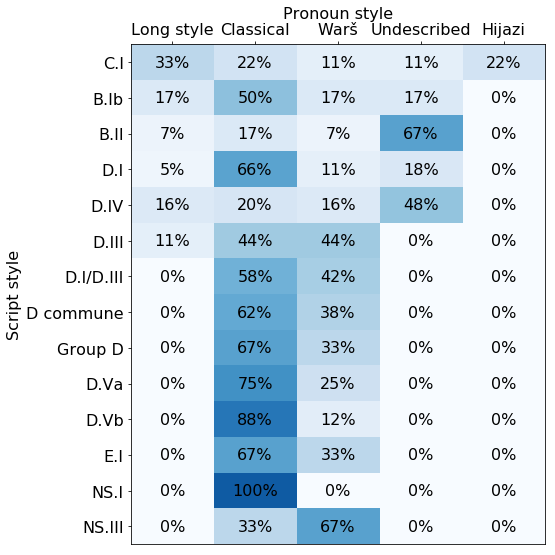

In [27]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.imshow(df_script_norm, cmap=plt.cm.Blues, aspect='auto', vmax=1.2)
ax.set_xticks(np.arange(df_script_norm.shape[1]))
ax.set_yticks(np.arange(df_script_norm.shape[0]))

ax.set_yticklabels(df_script_norm.index)
ax.set_xticklabels(df_script_norm.columns, rotation=0)
ax.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)

ax.set_xlabel('Pronoun style')
ax.set_ylabel('Script style')
ax.xaxis.set_label_position('top') 

for i in range(df_script_norm.shape[0]):
    for j in range(df_script_norm.shape[1]):
        text = ax.text(j, i, f'{100*df_script_norm.iloc[i, j]:0.0f}%',ha='center', va='center', color='k')

plt.tight_layout()
plt.savefig('scriptstyle.png', dpi=300)